In [929]:
from pgmpy.models import BayesianModel,BayesianNetwork 
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score, mean_squared_error,precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, ExpectationMaximization, IVEstimator
from pgmpy.inference import VariableElimination
import bnlearn as bn
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

# Read Data

In [935]:
crash = pd.read_csv('data/crash_nyc_2021.csv').reset_index().iloc[:,1:]
crash = crash.loc[(crash['Duration (min)']>0)&(crash['Duration (min)']<=150)].reset_index()
crash['Duration_class'] = pd.cut(crash['Duration (min)'], [0,30,60,90,120,150], right=True, labels=[0,1,2,3,4])
crash = crash.dropna()
#target_var = 'Duration (min)'
target_var = 'Duration_class'

column_clear = ['Start Date Time','Direction','County', 'Year', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', target_var]

crash['Start Date Time'] = pd.to_datetime(crash['Start Date Time'])

data = crash[crash['Start Date Time'].dt.year.isin([2021])].iloc[:,1:]

data = data[column_clear].iloc[:,1:]

In [885]:
train, test = train_test_split(data, test_size=0.25)

In [886]:
train_target = train.pop('Duration_class')

In [887]:
Xtrain, Xval, ytrain, yval = train_test_split(train, train_target, test_size=0.1, random_state=0)
valid = pd.concat([Xval, yval], axis='columns')
dfnum = pd.concat([Xtrain, ytrain], axis='columns')
dfnum

,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
1111,1,2,6,0,0,0,2,0,0,1,0,0
4378,3,0,6,0,0,0,2,1,1,1,1,1
1109,1,2,6,0,1,0,2,0,0,2,0,0
5019,1,0,6,0,0,0,2,0,1,1,1,2
4852,3,3,6,1,0,0,0,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4730,2,2,6,0,1,0,1,0,1,1,1,2
5361,2,2,6,1,0,1,2,0,1,2,1,2
3683,3,3,6,0,0,0,0,1,1,1,0,1
5460,4,3,6,0,0,1,1,1,1,2,1,2


In [888]:
# Get mape for regression task
def get_mape(model, df, col):
    # Get accuracy score by the model for the validation dataset df with target col
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    mape = mean_absolute_percentage_error(df[col], pred)
    print('MAPE -', mape)
    return mape

In [905]:
#Get accuracy for classification task
def get_acc(model, df, col):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = accuracy_score(df[col], pred)
    print('Accuracy -', acc)
    return acc

In [908]:
def get_acc_label(model, df, col, labels):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = precision_recall_fscore_support(df[col], pred, average=None, labels=labels)
    print('precision, recall, f1 -', acc)
    return acc

# Structure and Parameter Learning

[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [chow-liu]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


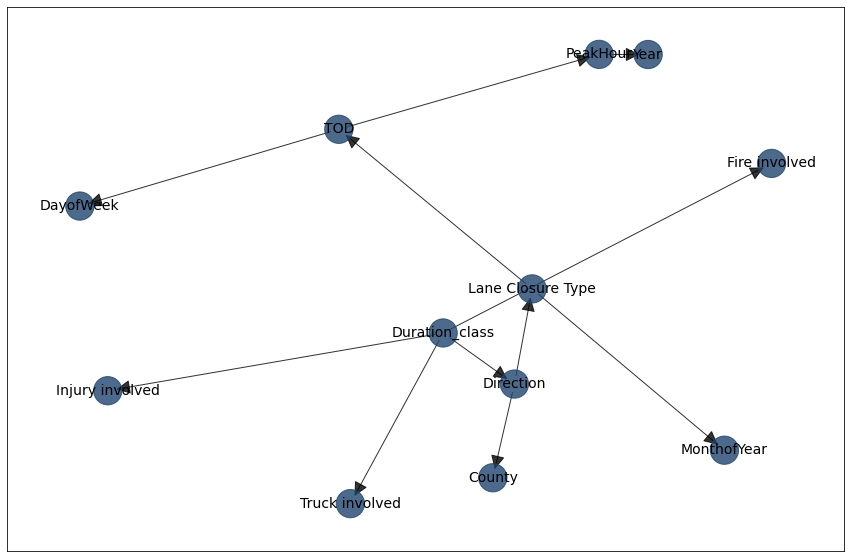

(Direction ⟂ Injury involved, Truck involved, Fire involved | Duration_class)
(County ⟂ Year, TOD, Duration_class, Fire involved, Injury involved, DayofWeek, Truck involved, PeakHour, MonthofYear, Lane Closure Type | Direction)
(Year ⟂ TOD, Duration_class, Fire involved, Injury involved, DayofWeek, Truck involved, Direction, MonthofYear, Lane Closure Type, County | PeakHour)
(TOD ⟂ Direction, County, Duration_class, Fire involved, Injury involved, Truck involved, MonthofYear | Lane Closure Type)
(PeakHour ⟂ Duration_class, Fire involved, DayofWeek, Injury involved, Truck involved, Direction, MonthofYear, Lane Closure Type, County | TOD)
(DayofWeek ⟂ Year, Duration_class, Fire involved, Injury involved, Truck involved, Direction, PeakHour, MonthofYear, Lane Closure Type, County | TOD)
(MonthofYear ⟂ Year, TOD, Duration_class, Fire involved, Injury involved, DayofWeek, Truck involved, Direction, PeakHour, County | Lane Closure Type)
(Injury involved ⟂ Year, TOD, Fire involved, DayofWeek,

In [909]:
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='cl', root_node='Duration_class', bw_list_method='nodes', verbose=3)
#DAG = bn.structure_learning.fit(data,methodtype='cl', scoretype='bdeu')
#DAG = bn.structure_learning.fit(data,methodtype='naivebayes', scoretype='bdeu', root_node='Duration_class')
# Plot graph
G = bn.plot(DAG)

# Parameter learning

#model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);
model = BayesianNetwork(ebunch=DAG['model_edges'])
bayes = BayesianEstimator(model=model, data = data)
model.fit(dfnum, estimator=BayesianEstimator, prior_type='BDeu',equivalent_sample_size=10,
          complete_samples_only=False)
model.local_independencies(bayes.variables)


# Validation

In [910]:
acc1 = get_acc(model, valid, 'Duration_class')

  0%|          | 0/395 [00:00<?, ?it/s]

     Duration_class
0                 1
1                 2
2                 0
3                 3
4                 0
..              ...
489               3
490               3
491               2
492               0
493               3

[494 rows x 1 columns]
Accuracy - 0.8441295546558705


In [912]:
acc2 = get_acc_label(model, valid, 'Duration_class', [0,1,2,3,4])

  0%|          | 0/395 [00:00<?, ?it/s]

     Duration_class
0                 1
1                 2
2                 0
3                 3
4                 0
..              ...
489               3
490               3
491               2
492               0
493               3

[494 rows x 1 columns]
precision, recall, f1 - (array([0.98342541, 0.91715976, 1.        , 0.42307692, 0.        ]), array([0.93193717, 0.99358974, 0.54054054, 1.        , 0.        ]), array([0.95698925, 0.95384615, 0.70175439, 0.59459459, 0.        ]), array([191, 156,  74,  44,  29], dtype=int64))


# Inference

In [902]:
inference = VariableElimination(model)
evidence = valid.iloc[0,:-1]
result=inference.query(variables=['Duration_class'], evidence=evidence)
print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0005 |
+-------------------+-----------------------+
| Duration_class(1) |                0.9931 |
+-------------------+-----------------------+
| Duration_class(2) |                0.0041 |
+-------------------+-----------------------+
| Duration_class(3) |                0.0010 |
+-------------------+-----------------------+
| Duration_class(4) |                0.0013 |
+-------------------+-----------------------+


# Prediction

In [913]:
result_pred = model.predict(test.iloc[:,:-1])

  0%|          | 0/991 [00:00<?, ?it/s]

In [919]:
acc_test=accuracy_score(test['Duration_class'], result_pred)
acc_label_test=precision_recall_fscore_support(test['Duration_class'], result_pred, labels=[0,1,2,3,4])
print("Test accuracy score -", acc_test)
print("Test precision, recall, F1-score and Sample Size -", acc_label_test)

Test accuracy score - 0.8807785888077859
Test precision, recall, F1-score and Sample Size - (array([0.99671593, 0.95017794, 1.        , 0.4334471 , 0.        ]), array([0.95590551, 0.99813084, 0.67164179, 1.        , 0.        ]), array([0.97588424, 0.97356427, 0.80357143, 0.6047619 , 0.        ]), array([635, 535, 268, 127,  79], dtype=int64))


In [928]:
test['Duration_class']
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3,4])
ypred = label_binarize(result_pred, classes=[0,1,2,3,4])

# AUC-ROC Curve

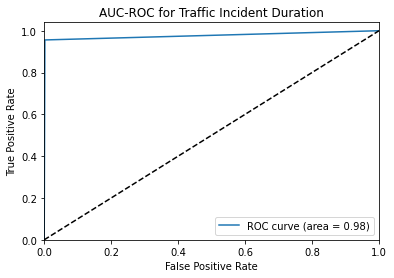

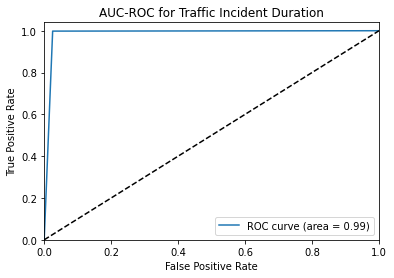

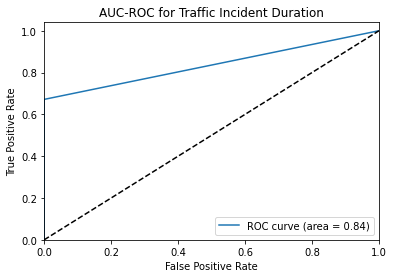

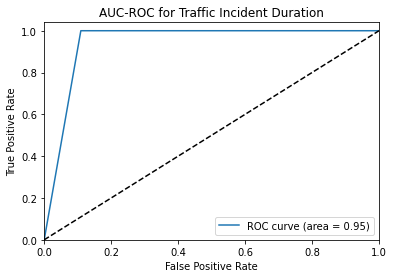

In [930]:
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3,4])
fpr, tpr = dict(), dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest[:,i], ypred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.04])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC for Traffic Incident Duration')
    plt.legend(loc='lower right')
    plt.show()